## Модели прогнозирования количества яиц по ВКО

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from IPython.display import display
import math
from prophet import Prophet
pd.set_option('display.max_columns', 130)


import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Подготовка данных и EDA

In [91]:
df = pd.read_excel("Датасет по яйцам.xlsx")
df = df[['Регион', 'Период', 'Яйца', 'Осадки', 'Поголовье: птица домашняя', 'Температура']]
df.sample(10)

,Регион,Период,Яйца,Осадки,Поголовье: птица домашняя,Температура
944,ЖАМБЫЛСКАЯ ОБЛАСТЬ,2017-02,6160.7,64.8,1156432.0,-2.192857
1651,ОБЛАСТЬ АБАЙ,2023-06,7328.7,17.8,735413.0,20.936667
2140,ТУРКЕСТАНСКАЯ ОБЛАСТЬ,2022-06,22877.8,1.5,1887691.0,29.256667
365,АТЫРАУСКАЯ ОБЛАСТЬ,2015-06,5047.9,0.0,259351.0,28.906667
45,АКМОЛИНСКАЯ ОБЛАСТЬ,2018-10,71926.1,35.3,7742916.0,5.232258
508,ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2017-05,15568.6,18.0,4087333.0,15.470968
1141,ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2023-07,14381.0,152.1,952399.0,23.793548
1926,РЕСПУБЛИКА КАЗАХСТАН,2021-03,385357.8,NaN,43622539.0,NaN
1015,ЖАМБЫЛСКАЯ ОБЛАСТЬ,2023-01,7926.1,26.9,1120670.0,-8.522581
1065,ЗАПАДНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ,2017-03,12327.3,21.2,920817.0,-2.719355


In [92]:
df_vko = df[df['Регион'] == 'ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛАСТЬ']
df_vko = df_vko.drop('Регион', axis = 'columns')
df_vko.head()

,Период,Яйца,Осадки,Поголовье: птица домашняя,Температура
480,2015-01,6106.2,29.4,3420122.0,-10.364516
481,2015-02,7131.1,33.4,3610458.0,-9.839286
482,2015-03,10886.9,41.2,3643041.0,-4.858065
483,2015-04,11777.5,50.6,3735974.0,6.830000
484,2015-05,18897.3,63.8,3509041.0,14.774194


In [93]:
df_vko = df_vko.rename(columns={'Яйца': 'Кол-во яиц'})
df_vko.head()

,Период,Кол-во яиц,Осадки,Поголовье: птица домашняя,Температура
480,2015-01,6106.2,29.4,3420122.0,-10.364516
481,2015-02,7131.1,33.4,3610458.0,-9.839286
482,2015-03,10886.9,41.2,3643041.0,-4.858065
483,2015-04,11777.5,50.6,3735974.0,6.830000
484,2015-05,18897.3,63.8,3509041.0,14.774194


In [94]:
df_vko['Период'] = pd.to_datetime(df_vko['Период'], format='%Y-%m')
df_vko.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 480 to 599
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Период                     120 non-null    datetime64[ns]
 1   Кол-во яиц                 120 non-null    float64       
 2   Осадки                     120 non-null    float64       
 3   Поголовье: птица домашняя  120 non-null    float64       
 4   Температура                120 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.6 KB


In [95]:
df_vko.isna().sum()

Период                       0
Кол-во яиц                   0
Осадки                       0
Поголовье: птица домашняя    0
Температура                  0
dtype: int64

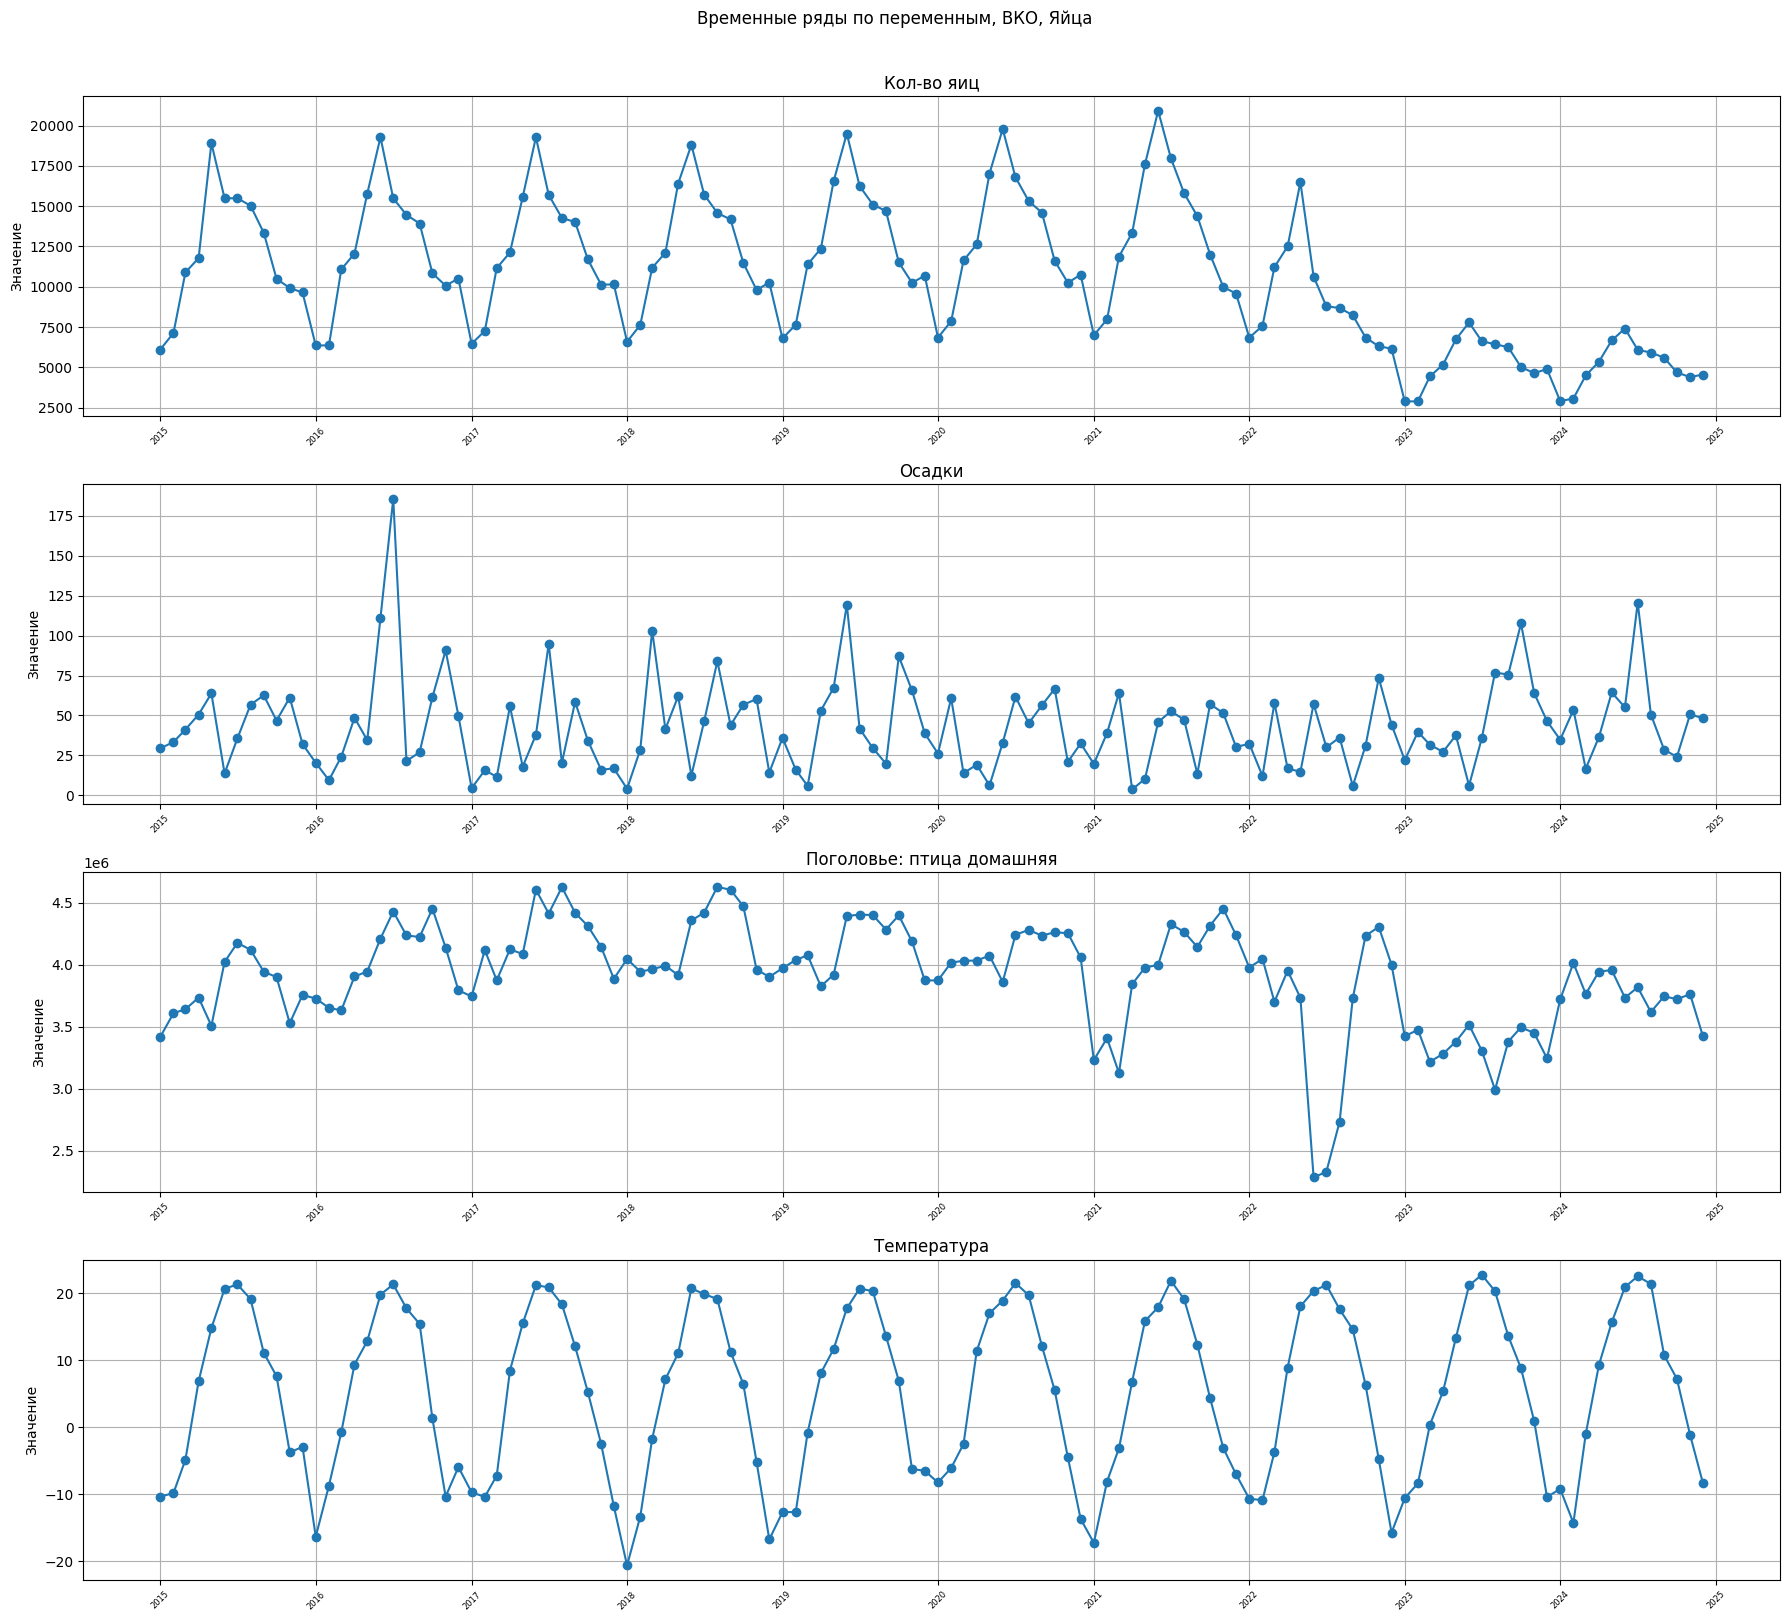

In [96]:
# Plot each variable in its own subplot
value_cols = [col for col in df_vko.columns if col not in ["Период"]]

n = len(value_cols)
plt.figure(figsize=(18, 4 * n))

for i, col in enumerate(value_cols, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_vko["Период"], df_vko[col], marker="o")
    plt.title(f"{col}")
    plt.grid(True)
    plt.ylabel("Значение")
    plt.xticks(rotation=45, fontsize = 6)

plt.suptitle("Временные ряды по переменным, ВКО, Яйца", y=1.01)
plt.tight_layout()
plt.show()

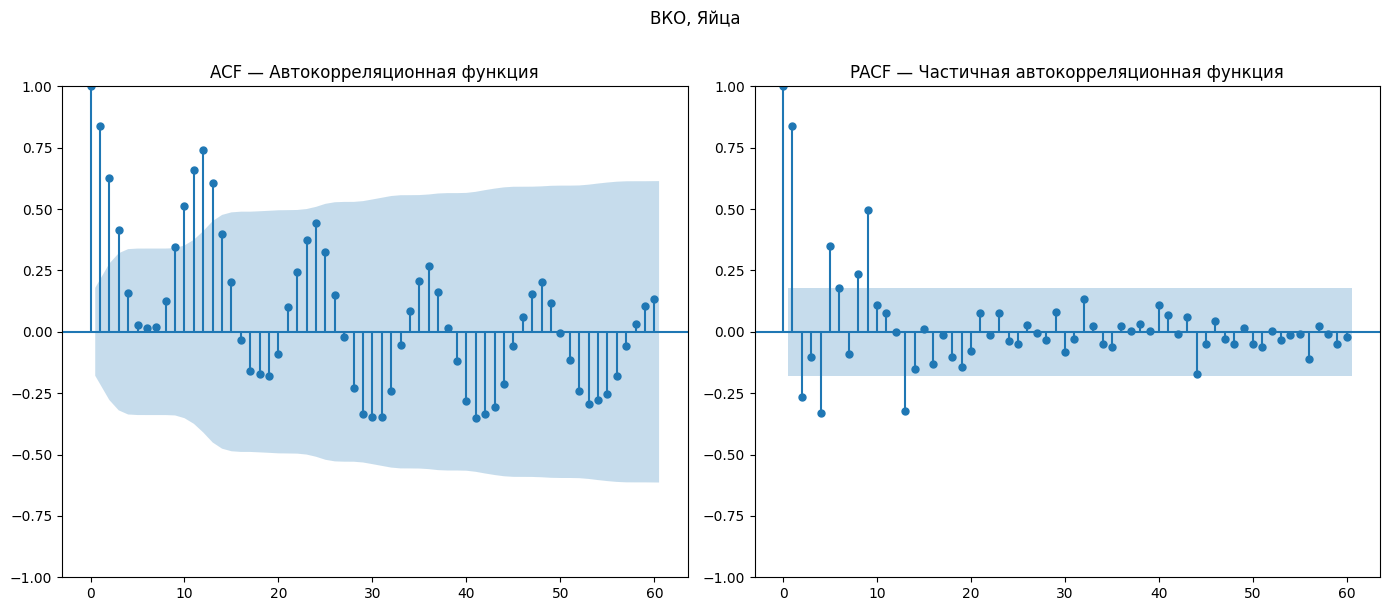

In [97]:
y = df_vko["Кол-во яиц"].sort_index()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(y, lags=60, ax=plt.gca(), title="ACF — Автокорреляционная функция")

plt.subplot(1, 2, 2)
plot_pacf(y, lags=60, ax=plt.gca(), title="PACF — Частичная автокорреляционная функция", method="ywm")
plt.suptitle("ВКО, Яйца", y=1.01)

plt.tight_layout()
plt.show()

Графики автокорреляционной и частичной автокорреляционной функций указывают на **сильную взаимосвязь показателей текущего месяца со значениями следующих 3 месяцев** и на возможную **годовую сезонность** (пик на +12 месяцев). 

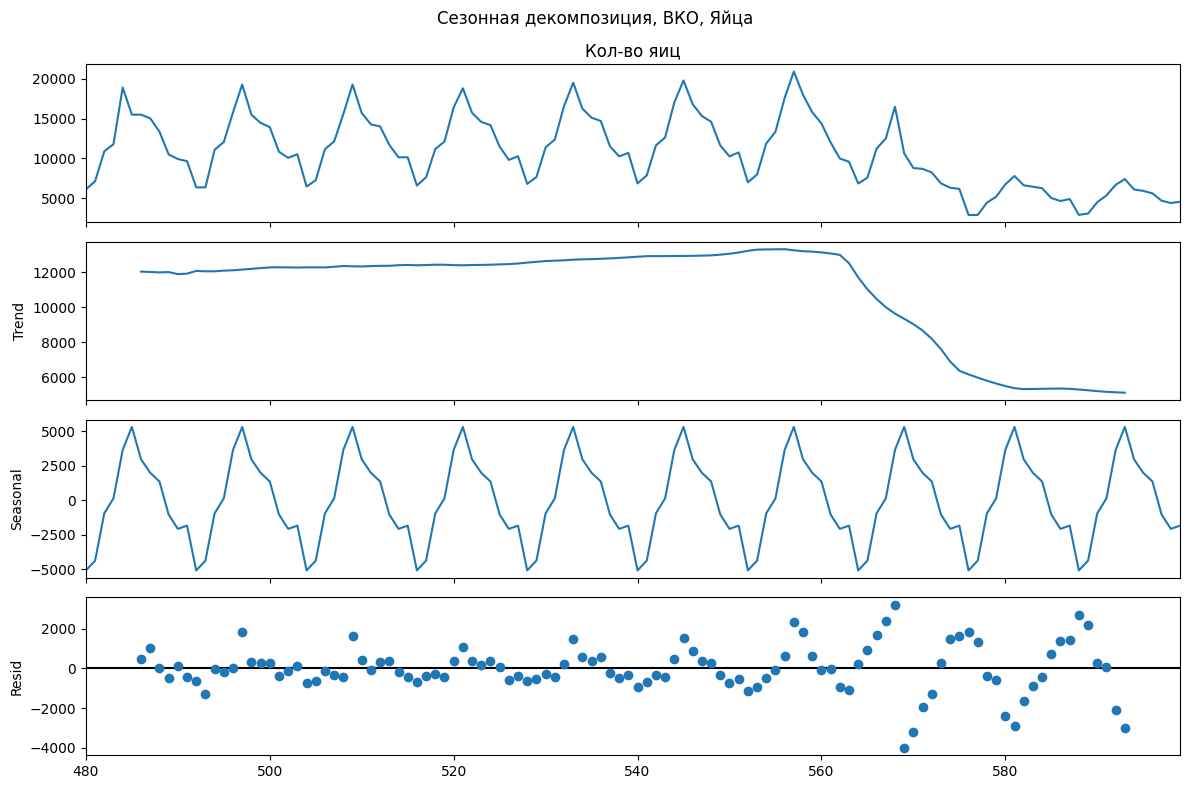

In [98]:
# Perform decomposition (period=12 for monthly data)
decomposition = seasonal_decompose(df_vko["Кол-во яиц"], model="additive", period=12)

# Plot with larger figure size
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Сезонная декомпозиция, ВКО, Яйца", fontsize=12)
plt.tight_layout()
plt.show()


In [99]:
# Run ADF test
result = adfuller(df_vko["Кол-во яиц"])

# Display results
print("📊 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] < 0.05:
    print("✅ The series is likely **stationary** (reject H₀).")
else:
    print("❌ The series is likely **non-stationary** (fail to reject H₀).")


📊 Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.1505
p-value: 0.9442
Critical Value (1%): -3.4930
Critical Value (5%): -2.8890
Critical Value (10%): -2.5814
❌ The series is likely **non-stationary** (fail to reject H₀).


Результаты теста ADF указывают на **нестационарность** временного ряда.

In [100]:
df_vko

,Период,Кол-во яиц,Осадки,Поголовье: птица домашняя,Температура
480,2015-01-01,6106.2,29.4,3420122.0,-10.364516
481,2015-02-01,7131.1,33.4,3610458.0,-9.839286
482,2015-03-01,10886.9,41.2,3643041.0,-4.858065
483,2015-04-01,11777.5,50.6,3735974.0,6.830000
484,2015-05-01,18897.3,63.8,3509041.0,14.774194
...,...,...,...,...,...
595,2024-08-01,5916.0,50.6,3620230.0,21.361290
596,2024-09-01,5600.6,28.6,3747315.0,10.743333
597,2024-10-01,4681.3,24.1,3723542.0,7.209677
598,2024-11-01,4394.2,50.7,3764365.0,-1.160000


In [101]:
# Создание лагов t-1 до t-6 для переменных
for lag in range(1, 7):
    df_vko[f"Яйца_t-{lag}"] = df_vko["Кол-во яиц"].shift(lag)
    df_vko[f"Температура_t-{lag}"] = df_vko["Температура"].shift(lag)
    df_vko[f"Осадки_t-{lag}"] = df_vko["Осадки"].shift(lag)
    df_vko[f"Поголовье: птица домашняя_t-{lag}"] = df_vko["Поголовье: птица домашняя"].shift(lag)

df_vko_full = df_vko[["Период", "Кол-во яиц", 
                            "Яйца_t-1", "Яйца_t-2", "Яйца_t-3", "Яйца_t-4", "Яйца_t-5", "Яйца_t-6",
                            "Температура", "Температура_t-1", "Температура_t-2", "Температура_t-3", "Температура_t-4", "Температура_t-5", "Температура_t-6",
                            "Осадки", "Осадки_t-1", "Осадки_t-2", "Осадки_t-3", "Осадки_t-4", "Осадки_t-5", "Осадки_t-6",
                            "Поголовье: птица домашняя", "Поголовье: птица домашняя_t-1", "Поголовье: птица домашняя_t-2", "Поголовье: птица домашняя_t-3", "Поголовье: птица домашняя_t-4", "Поголовье: птица домашняя_t-5", "Поголовье: птица домашняя_t-6"]]
df_vko_full

,Период,Кол-во яиц,Яйца_t-1,Яйца_t-2,Яйца_t-3,Яйца_t-4,Яйца_t-5,Яйца_t-6,Температура,Температура_t-1,Температура_t-2,Температура_t-3,Температура_t-4,Температура_t-5,Температура_t-6,Осадки,Осадки_t-1,Осадки_t-2,Осадки_t-3,Осадки_t-4,Осадки_t-5,Осадки_t-6,Поголовье: птица домашняя,Поголовье: птица домашняя_t-1,Поголовье: птица домашняя_t-2,Поголовье: птица домашняя_t-3,Поголовье: птица домашняя_t-4,Поголовье: птица домашняя_t-5,Поголовье: птица домашняя_t-6
480,2015-01-01,6106.2,NaN,NaN,NaN,NaN,NaN,NaN,-10.364516,NaN,NaN,NaN,NaN,NaN,NaN,29.4,NaN,NaN,NaN,NaN,NaN,NaN,3420122.0,NaN,NaN,NaN,NaN,NaN,NaN
481,2015-02-01,7131.1,6106.2,NaN,NaN,NaN,NaN,NaN,-9.839286,-10.364516,NaN,NaN,NaN,NaN,NaN,33.4,29.4,NaN,NaN,NaN,NaN,NaN,3610458.0,3420122.0,NaN,NaN,NaN,NaN,NaN
482,2015-03-01,10886.9,7131.1,6106.2,NaN,NaN,NaN,NaN,-4.858065,-9.839286,-10.364516,NaN,NaN,NaN,NaN,41.2,33.4,29.4,NaN,NaN,NaN,NaN,3643041.0,3610458.0,3420122.0,NaN,NaN,NaN,NaN
483,2015-04-01,11777.5,10886.9,7131.1,6106.2,NaN,NaN,NaN,6.830000,-4.858065,-9.839286,-10.364516,NaN,NaN,NaN,50.6,41.2,33.4,29.4,NaN,NaN,NaN,3735974.0,3643041.0,3610458.0,3420122.0,NaN,NaN,NaN
484,2015-05-01,18897.3,11777.5,10886.9,7131.1,6106.2,NaN,NaN,14.774194,6.830000,-4.858065,-9.839286,-10.364516,NaN,NaN,63.8,50.6,41.2,33.4,29.4,NaN,NaN,3509041.0,3735974.0,3643041.0,3610458.0,3420122.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2024-08-01,5916.0,6088.3,7405.6,6670.2,5347.9,4495.1,3066.1,21.361290,22.509677,20.903333,15.641935,9.290000,-1.012903,-14.289655,50.6,120.6,55.1,64.4,36.5,16.7,53.5,3620230.0,3819784.0,3735289.0,3958391.0,3946116.0,3765672.0,4015633.0
596,2024-09-01,5600.6,5916.0,6088.3,7405.6,6670.2,5347.9,4495.1,10.743333,21.361290,22.509677,20.903333,15.641935,9.290000,-1.012903,28.6,50.6,120.6,55.1,64.4,36.5,16.7,3747315.0,3620230.0,3819784.0,3735289.0,3958391.0,3946116.0,3765672.0
597,2024-10-01,4681.3,5600.6,5916.0,6088.3,7405.6,6670.2,5347.9,7.209677,10.743333,21.361290,22.509677,20.903333,15.641935,9.290000,24.1,28.6,50.6,120.6,55.1,64.4,36.5,3723542.0,3747315.0,3620230.0,3819784.0,3735289.0,3958391.0,3946116.0
598,2024-11-01,4394.2,4681.3,5600.6,5916.0,6088.3,7405.6,6670.2,-1.160000,7.209677,10.743333,21.361290,22.509677,20.903333,15.641935,50.7,24.1,28.6,50.6,120.6,55.1,64.4,3764365.0,3723542.0,3747315.0,3620230.0,3819784.0,3735289.0,3958391.0


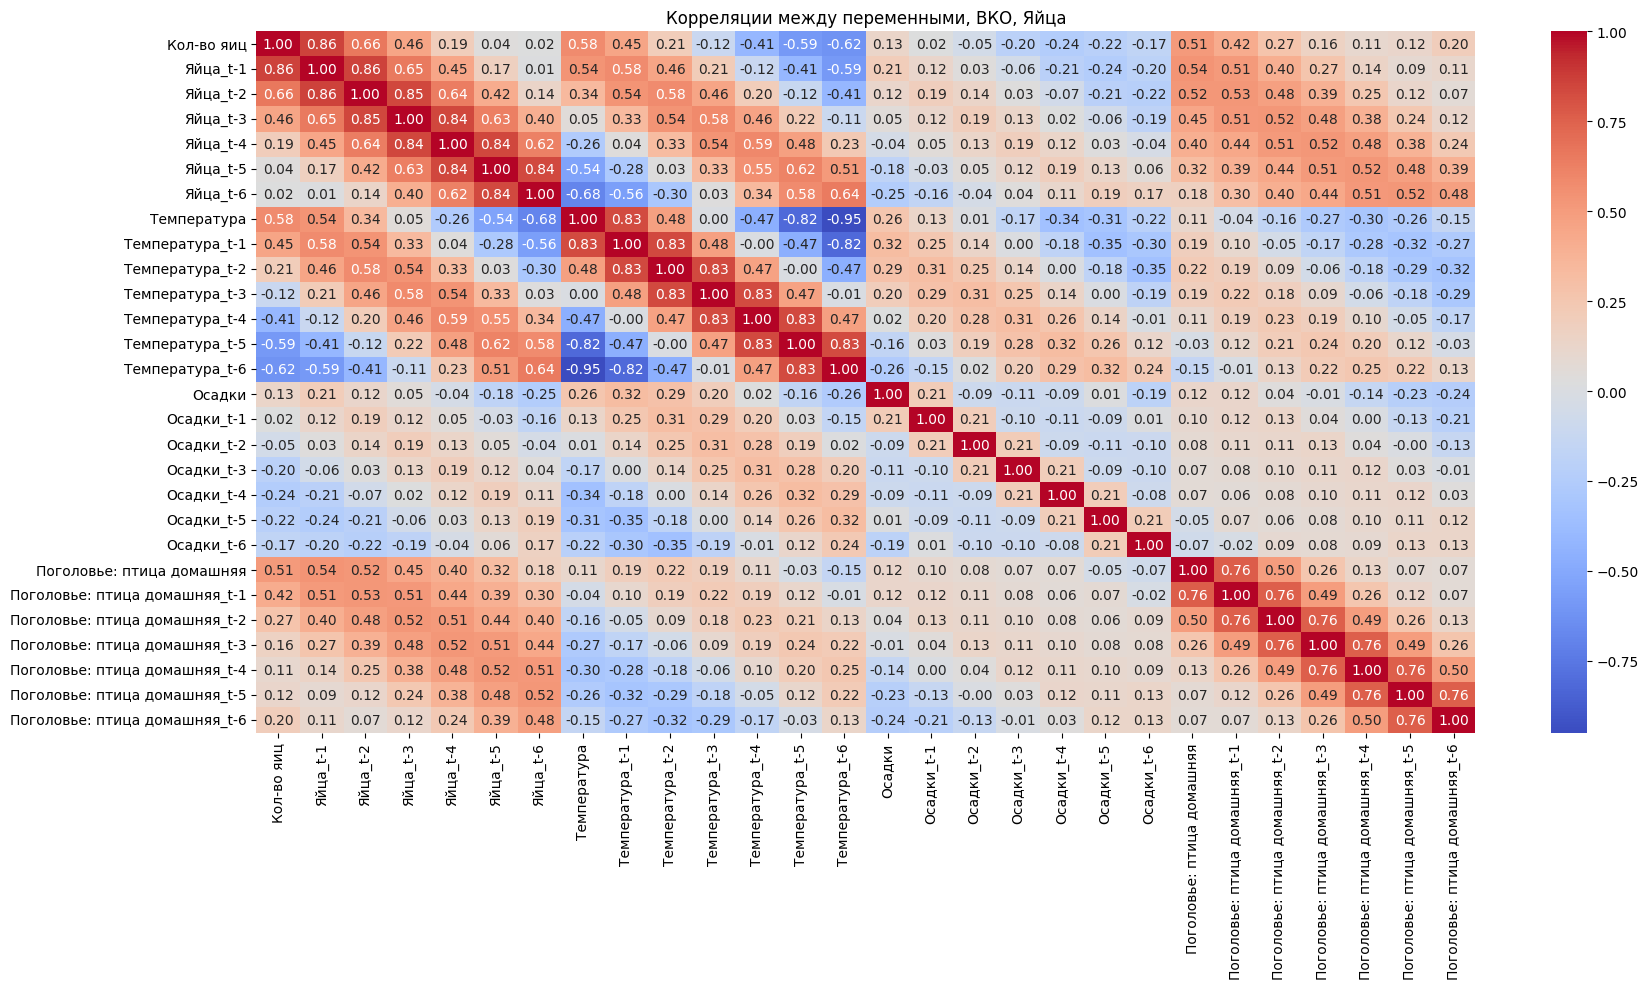

In [102]:
df_corr = df_vko_full[[col for col in df_vko_full.columns if col not in ["Период"]]].dropna().copy()

# 1. Correlation matrix
corr_matrix = df_corr.corr()

# 2. Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляции между переменными, ВКО, Яйца")
plt.tight_layout()
plt.show()

*ВЫВОДЫ ПО КОРРЕЛЯЦИИ*

In [103]:
# Set your target variable
target_var = "Кол-во яиц"

# Get correlations with the target variable
target_corr = corr_matrix[target_var].drop(target_var)  # exclude self-correlation

# Keep only features with |correlation| >= 0.5
selected_vars = target_corr[abs(target_corr) >= 0.5].index.tolist()

print("✅ Отобранные переменные с корреляцией >= 0.5:")
print(selected_vars)

# Optionally: create new dataframe with selected variables + target
df_selected = df_vko_full[['Период'] + selected_vars + [target_var]]
df_selected

✅ Отобранные переменные с корреляцией >= 0.5:
['Яйца_t-1', 'Яйца_t-2', 'Температура', 'Температура_t-5', 'Температура_t-6', 'Поголовье: птица домашняя']


,Период,Яйца_t-1,Яйца_t-2,Температура,Температура_t-5,Температура_t-6,Поголовье: птица домашняя,Кол-во яиц
480,2015-01-01,NaN,NaN,-10.364516,NaN,NaN,3420122.0,6106.2
481,2015-02-01,6106.2,NaN,-9.839286,NaN,NaN,3610458.0,7131.1
482,2015-03-01,7131.1,6106.2,-4.858065,NaN,NaN,3643041.0,10886.9
483,2015-04-01,10886.9,7131.1,6.830000,NaN,NaN,3735974.0,11777.5
484,2015-05-01,11777.5,10886.9,14.774194,NaN,NaN,3509041.0,18897.3
...,...,...,...,...,...,...,...,...
595,2024-08-01,6088.3,7405.6,21.361290,-1.012903,-14.289655,3620230.0,5916.0
596,2024-09-01,5916.0,6088.3,10.743333,9.290000,-1.012903,3747315.0,5600.6
597,2024-10-01,5600.6,5916.0,7.209677,15.641935,9.290000,3723542.0,4681.3
598,2024-11-01,4681.3,5600.6,-1.160000,20.903333,15.641935,3764365.0,4394.2


In [104]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()

X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Кол-во яиц"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
6,Поголовье: птица домашняя,1.518450
4,Температура_t-5,4.850145
2,Яйца_t-2,5.921141
1,Яйца_t-1,6.729001
3,Температура,10.658737
5,Температура_t-6,13.935103
0,const,107.002598


Step-by-Step Strategy to Handle High VIFs:

Sort VIFs in descending order
Drop variables one at a time, starting with the one that has the highest VIF.

Check domain relevance
Keep variables that are theoretically important or core to your hypothesis, even if VIF is high.

Evaluate correlation matrix
If two variables have high correlation with each other, and both have high VIFs, drop the one less correlated with the target.

Recalculate VIF after each drop
After dropping one variable, recalculate all VIFs. Sometimes removing just one variable significantly reduces others.

Use stepwise selection (optional)
Automated methods like backward elimination can help drop redundant predictors based on model fit and VIF thresholds.

In [105]:
df_selected = df_selected.drop(columns = ['Температура_t-6', 'Яйца_t-2'])
df_selected

,Период,Яйца_t-1,Температура,Температура_t-5,Поголовье: птица домашняя,Кол-во яиц
480,2015-01-01,NaN,-10.364516,NaN,3420122.0,6106.2
481,2015-02-01,6106.2,-9.839286,NaN,3610458.0,7131.1
482,2015-03-01,7131.1,-4.858065,NaN,3643041.0,10886.9
483,2015-04-01,10886.9,6.830000,NaN,3735974.0,11777.5
484,2015-05-01,11777.5,14.774194,NaN,3509041.0,18897.3
...,...,...,...,...,...,...
595,2024-08-01,6088.3,21.361290,-1.012903,3620230.0,5916.0
596,2024-09-01,5916.0,10.743333,9.290000,3747315.0,5600.6
597,2024-10-01,5600.6,7.209677,15.641935,3723542.0,4681.3
598,2024-11-01,4681.3,-1.160000,20.903333,3764365.0,4394.2


In [106]:
df_vif = df_selected[[col for col in df_selected.columns if col not in ["Период"]]].dropna().copy()
X_vif = add_constant(df_vif[[i for i in df_vif.columns if i != "Кол-во яиц"]])

vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_data.sort_values('VIF')

,Variable,VIF
4,Поголовье: птица домашняя,1.509132
1,Яйца_t-1,2.100933
3,Температура_t-5,3.091215
2,Температура,3.603913
0,const,96.956611


In [107]:
df_selected = df_selected.dropna().copy()
df_selected

,Период,Яйца_t-1,Температура,Температура_t-5,Поголовье: птица домашняя,Кол-во яиц
485,2015-06-01,18897.3,20.636667,-10.364516,4023589.0,15488.8
486,2015-07-01,15488.8,21.306452,-9.839286,4177986.0,15488.8
487,2015-08-01,15488.8,19.096774,-4.858065,4121550.0,15028.2
488,2015-09-01,15028.2,11.086667,6.830000,3945097.0,13342.8
489,2015-10-01,13342.8,7.603226,14.774194,3901846.0,10493.2
...,...,...,...,...,...,...
595,2024-08-01,6088.3,21.361290,-1.012903,3620230.0,5916.0
596,2024-09-01,5916.0,10.743333,9.290000,3747315.0,5600.6
597,2024-10-01,5600.6,7.209677,15.641935,3723542.0,4681.3
598,2024-11-01,4681.3,-1.160000,20.903333,3764365.0,4394.2


### Models

#### Многофакторная регрессия

In [108]:
# def forward_selection(data, target, candidate_features, criterion="adj_r2"):
#     remaining = list(candidate_features)
#     selected = []
#     best_score = -float("inf")
#     best_model = None

#     while remaining:
#         scores_with_candidates = []
#         for candidate in remaining:
#             features = selected + [candidate]
#             X = sm.add_constant(data[features])
#             y = data[target]
#             model = sm.OLS(y, X).fit()

#             if criterion == "adj_r2":
#                 score = model.rsquared_adj
#             elif criterion == "aic":
#                 score = -model.aic  # negative for maximizing
#             else:
#                 raise ValueError("criterion must be 'adj_r2' or 'aic'")

#             scores_with_candidates.append((score, candidate, model))

#         scores_with_candidates.sort(reverse=True)
#         best_new_score, best_candidate, model = scores_with_candidates[0]

#         if best_new_score > best_score:
#             remaining.remove(best_candidate)
#             selected.append(best_candidate)
#             best_score = best_new_score
#             best_model = model
#             print(f"✅ Added: {best_candidate}, {criterion.upper()}: {best_score:.4f}")
#         else:
#             print("⛔ No improvement. Stopping.")
#             break

#     return selected, best_model


In [109]:
# Define target and features
y = df_selected["Кол-во яиц"]
X = df_selected.drop(columns=["Период", "Кол-во яиц"])

# Add constant term
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Кол-во яиц   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     137.1
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           8.39e-42
Time:                        20:19:42   Log-Likelihood:                -1025.1
No. Observations:                 115   AIC:                             2060.
Df Residuals:                     110   BIC:                             2074.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [110]:
df_selected

,Период,Яйца_t-1,Температура,Температура_t-5,Поголовье: птица домашняя,Кол-во яиц
485,2015-06-01,18897.3,20.636667,-10.364516,4023589.0,15488.8
486,2015-07-01,15488.8,21.306452,-9.839286,4177986.0,15488.8
487,2015-08-01,15488.8,19.096774,-4.858065,4121550.0,15028.2
488,2015-09-01,15028.2,11.086667,6.830000,3945097.0,13342.8
489,2015-10-01,13342.8,7.603226,14.774194,3901846.0,10493.2
...,...,...,...,...,...,...
595,2024-08-01,6088.3,21.361290,-1.012903,3620230.0,5916.0
596,2024-09-01,5916.0,10.743333,9.290000,3747315.0,5600.6
597,2024-10-01,5600.6,7.209677,15.641935,3723542.0,4681.3
598,2024-11-01,4681.3,-1.160000,20.903333,3764365.0,4394.2


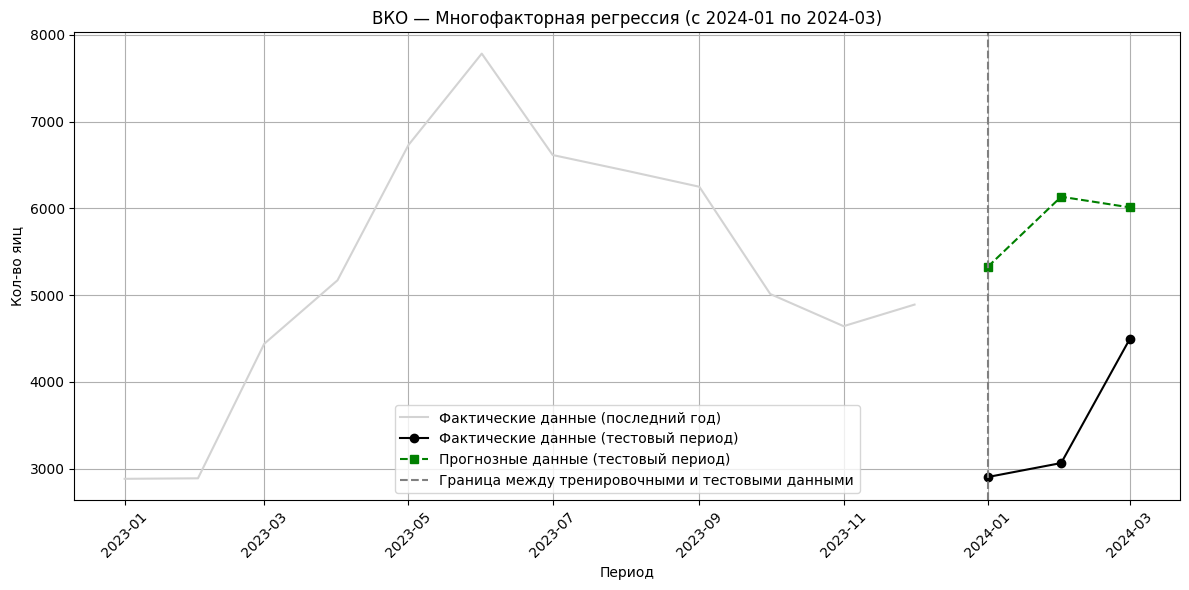

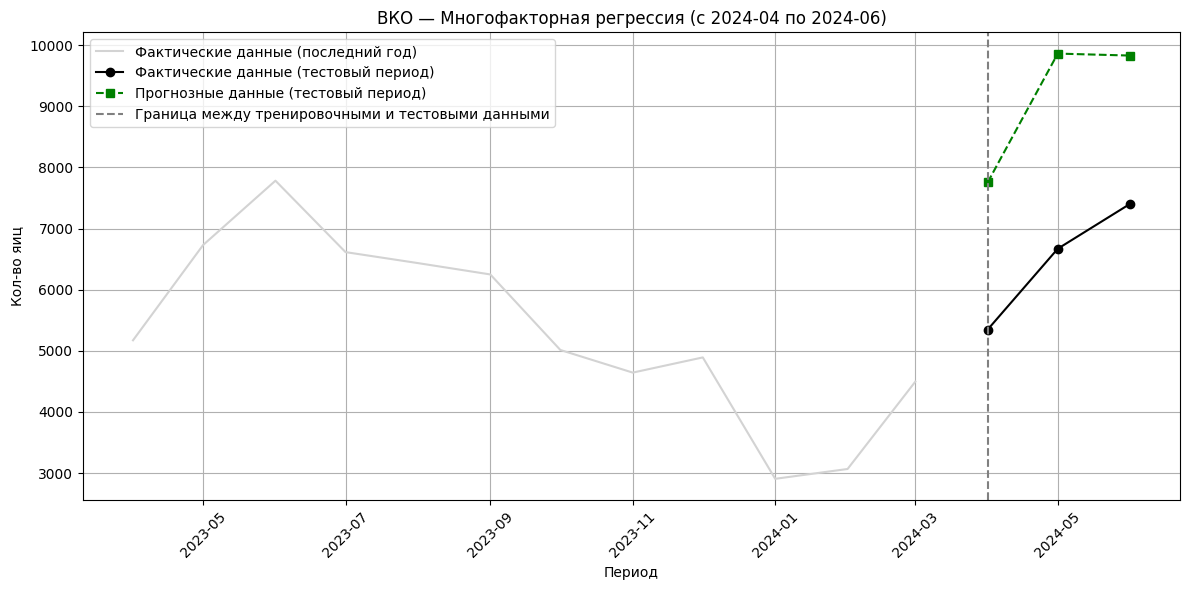

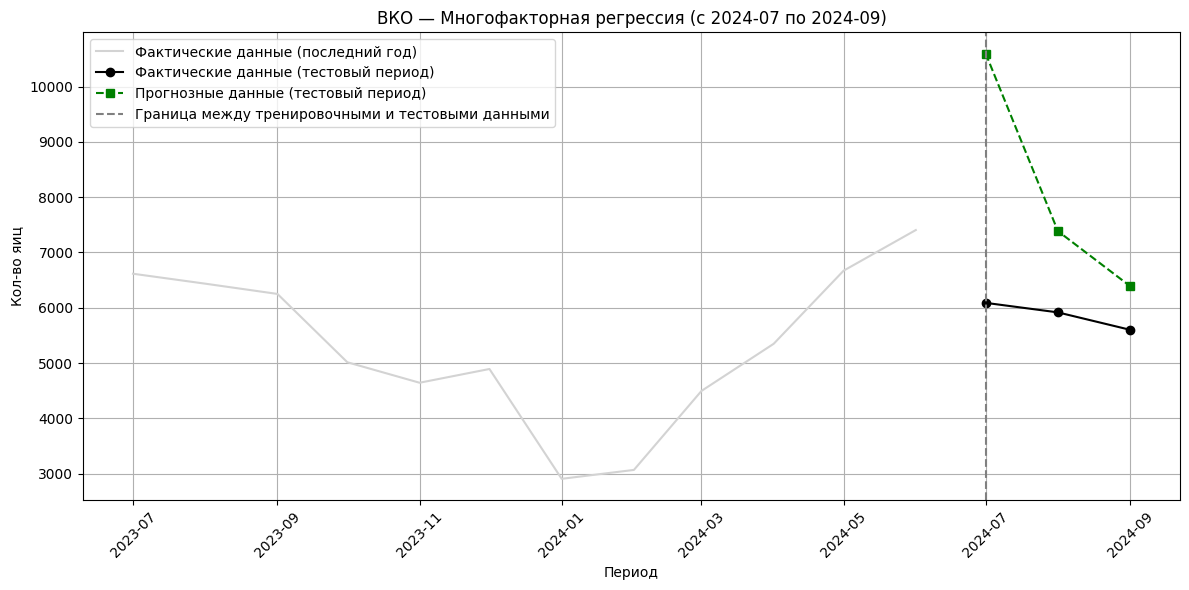

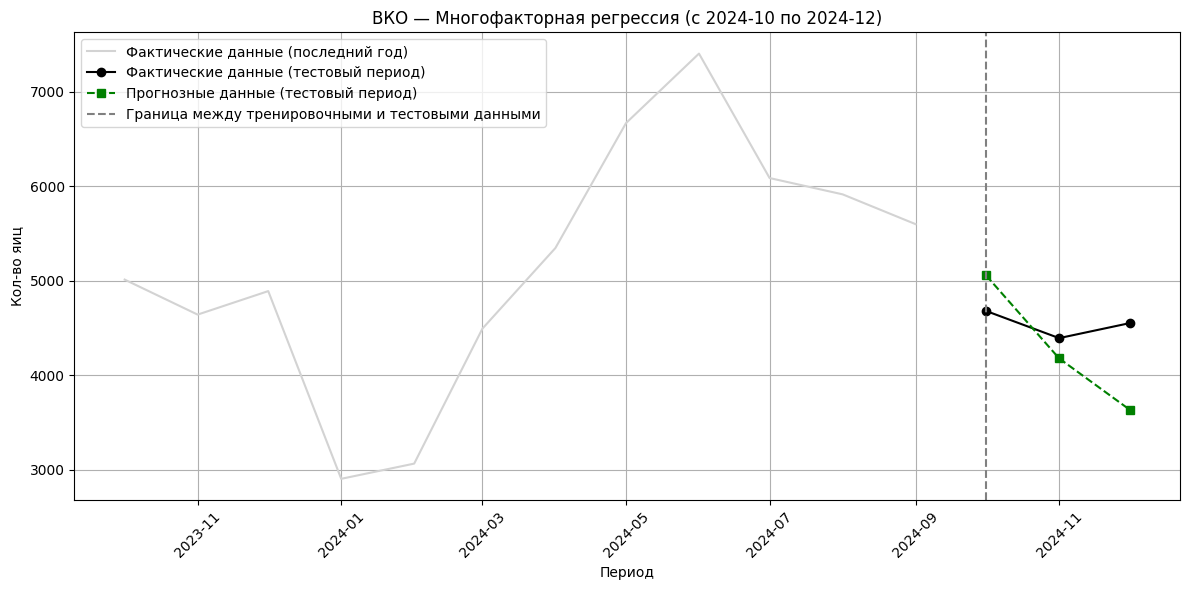

In [111]:
df = df_selected.sort_values("Период").copy()

target = "Кол-во яиц"
features = [col for col in df_selected.columns if col not in ['Период', 'Кол-во яиц']]

results = []

# Define 4 rolling test sets for 2024
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Многофакторная регрессия (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [112]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-01 to 2024-03  2421.263262  2336.137495  72.408296
1  2024-04 to 2024-06  2701.092500  2676.191893  41.894262
2  2024-07 to 2024-09  2775.833890  2256.055711  37.666281
3  2024-10 to 2024-12   585.408147   502.451280  11.016811
4             Average  2120.899450  1942.709095  40.746413


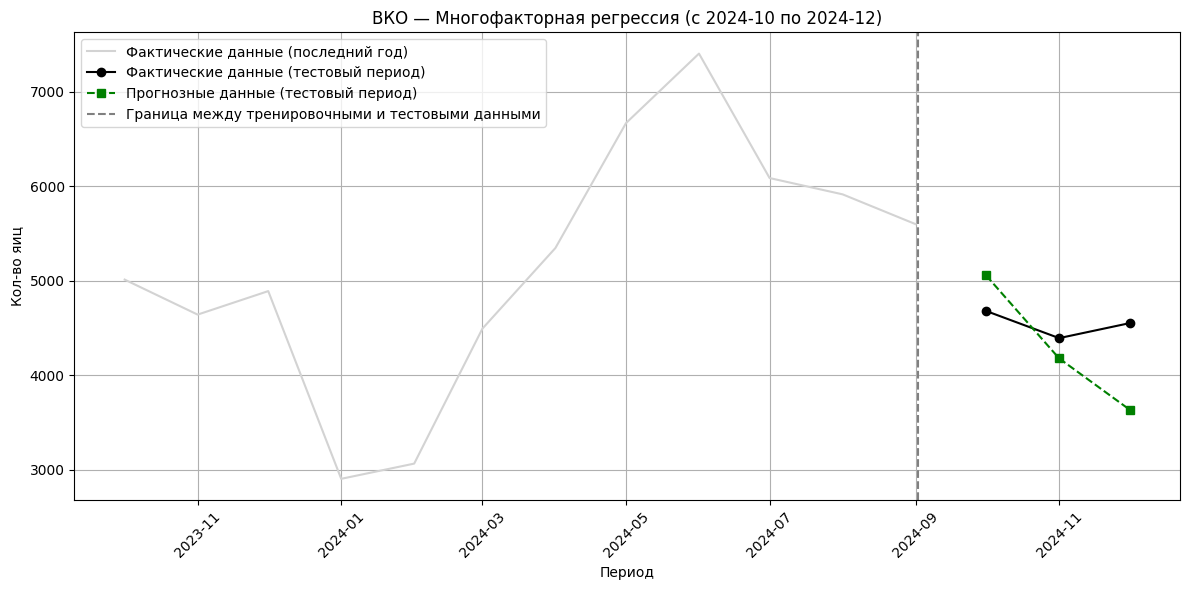

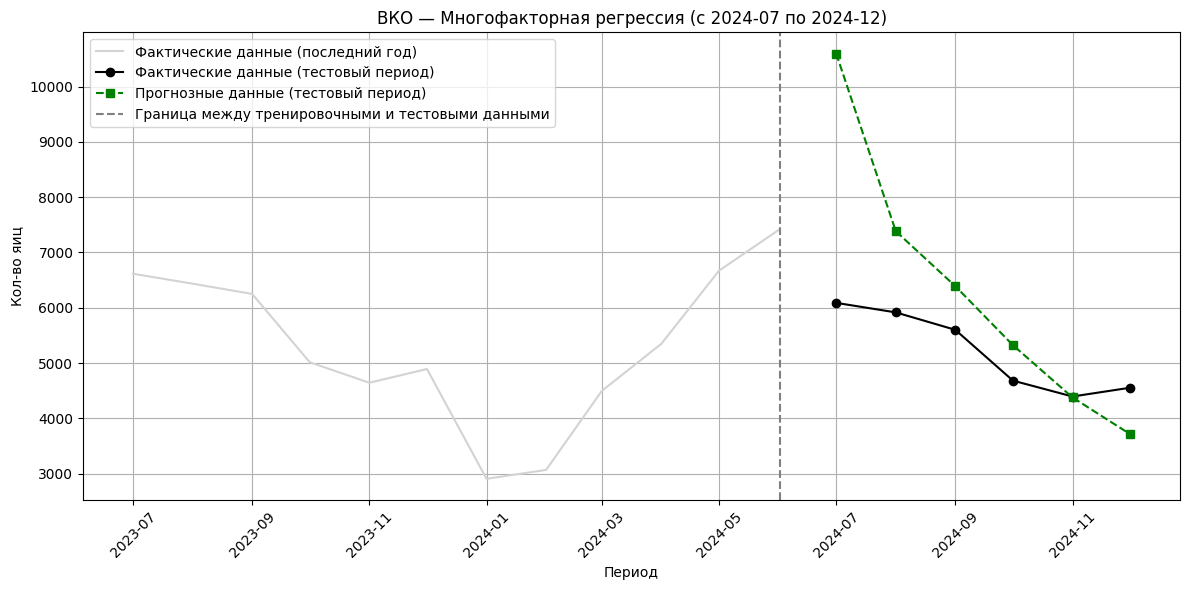

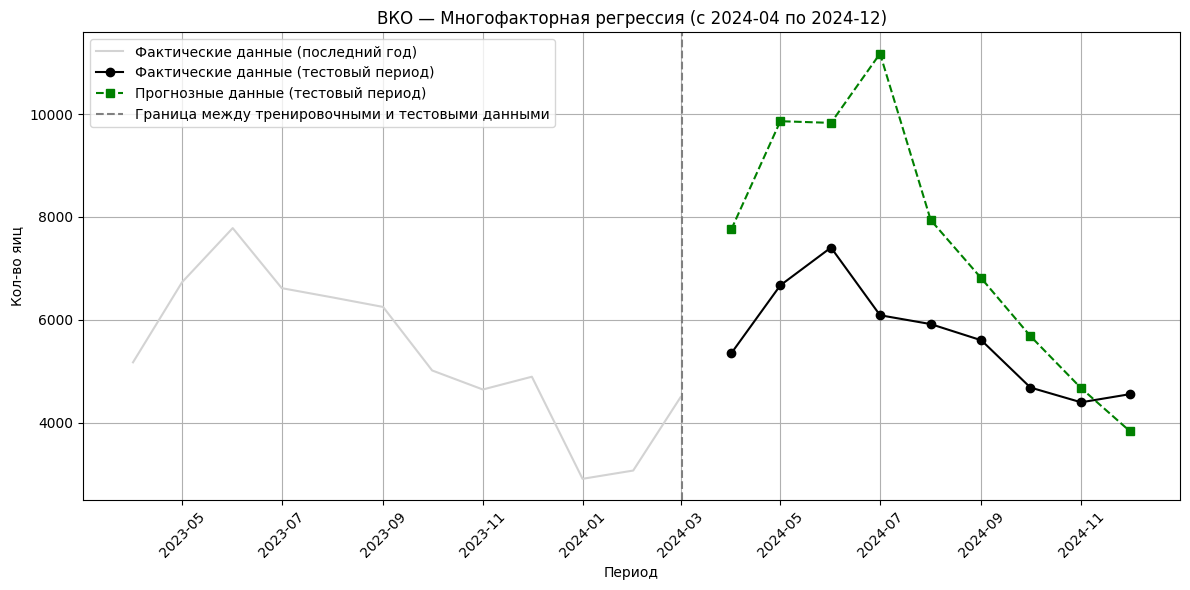

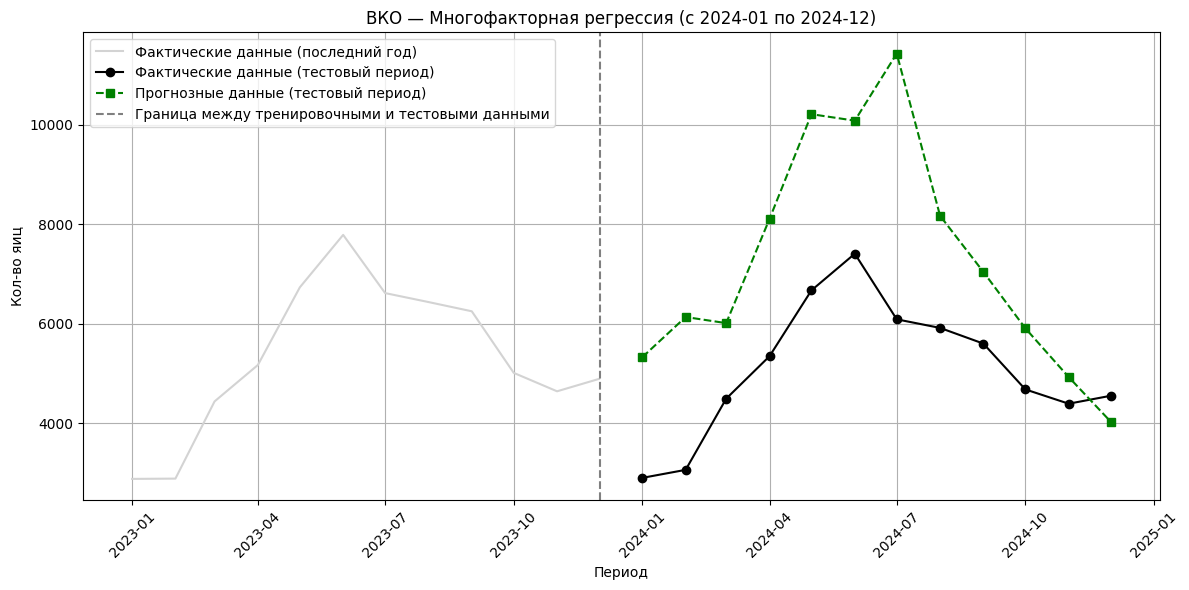

In [113]:
results = []

# Define 4 rolling test sets for 2024
horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split data
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    X_train = sm.add_constant(train_df[features])
    y_train = train_df[target]

    X_test = sm.add_constant(test_df[features])
    y_test = test_df[target]

    # Fit and predict
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        # "R²": r2
    })
    plt.figure(figsize=(12, 6))
    last_train_year = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train_year["Период"], last_train_year[target], color="lightgray", label="Фактические данные (последний год)")

    plt.plot(test_df["Период"], y_test.values, marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred.values, marker="s", linestyle="--", color="green", label="Прогнозные данные (тестовый период)")

    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Многофакторная регрессия (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [114]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
avg_row = results_df.mean(numeric_only=True).to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

# Show results
print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-10 to 2024-12   585.408147   502.451280  11.016811
1  2024-07 to 2024-12  2009.684493  1377.741244  24.255573
2  2024-04 to 2024-12  2471.175754  2038.890956  34.289275
3  2024-01 to 2024-12  2621.942459  2273.185591  46.583281
4             Average  1922.052713  1548.067268  29.036235


#### SARIMA (auto-arima)

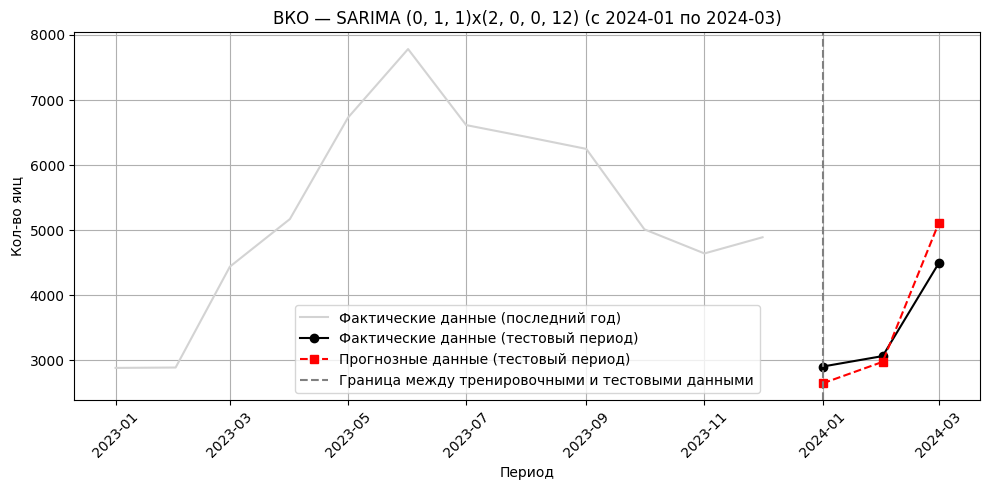

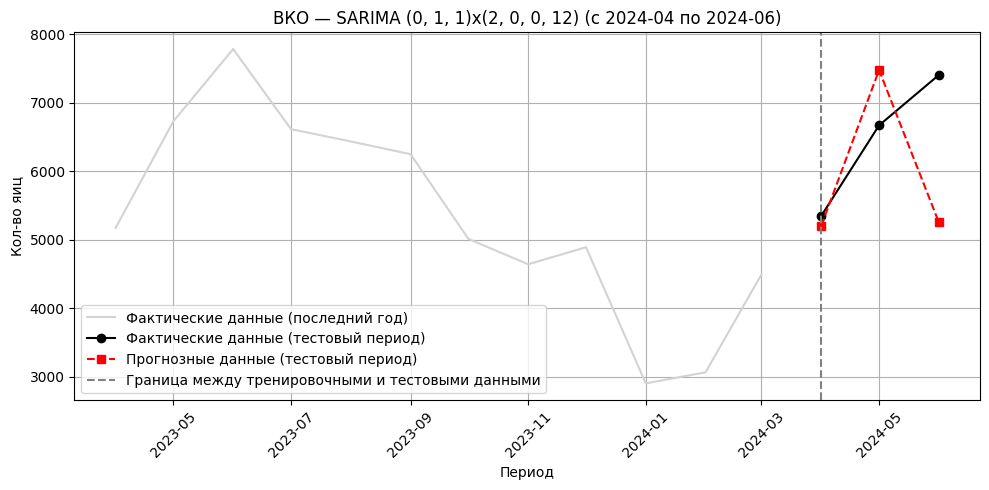

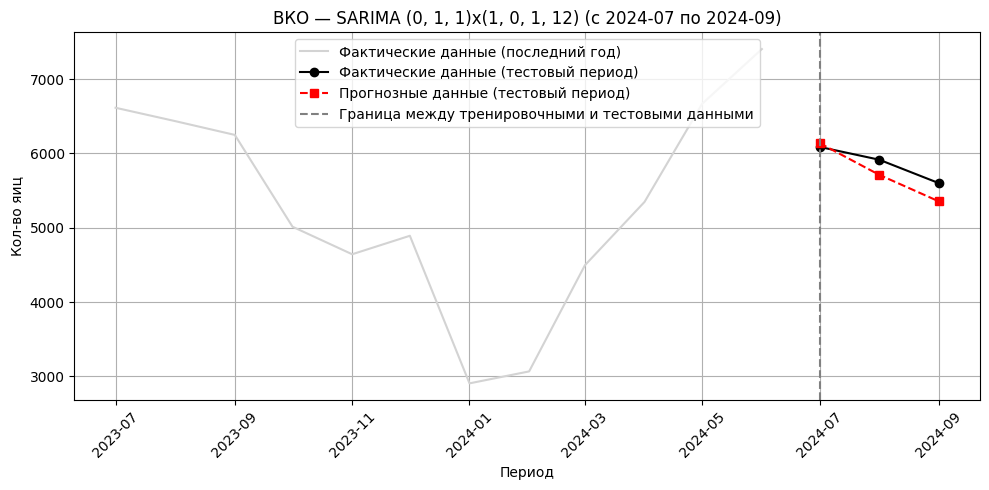

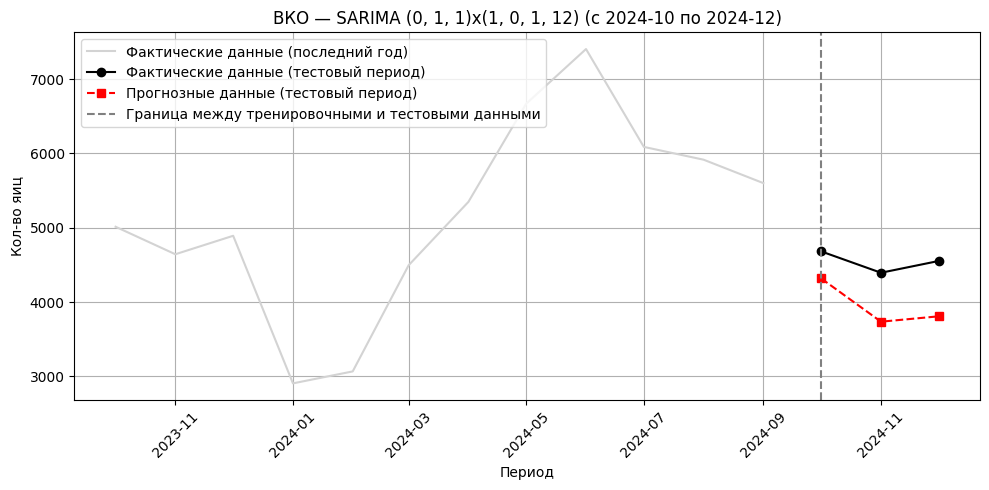

In [115]:
results = []

# Определим 4 тестовых периода на 3 месяца
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Разделим данные
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=3)
        forecast = pd.Series(forecast).reset_index(drop=True)


        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMA {model.order}x{model.seasonal_order} (с {test_start.strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        # print("Zero values in y_test:", (y_test == 0).sum())


    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [116]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-01 to 2024-03   389.873110   321.499060   8.506548    (0, 1, 1)   
1  2024-04 to 2024-06  1328.504212  1034.302780  14.619550    (0, 1, 1)   
2  2024-07 to 2024-09   186.408804   166.632810   2.886429    (0, 1, 1)   
3  2024-10 to 2024-12   611.651197   589.518452  13.049027    (0, 1, 1)   
4             Average   629.109331   527.988275   9.765388          NaN   

  Seasonal order  
0  (2, 0, 0, 12)  
1  (2, 0, 0, 12)  
2  (1, 0, 1, 12)  
3  (1, 0, 1, 12)  
4            NaN  


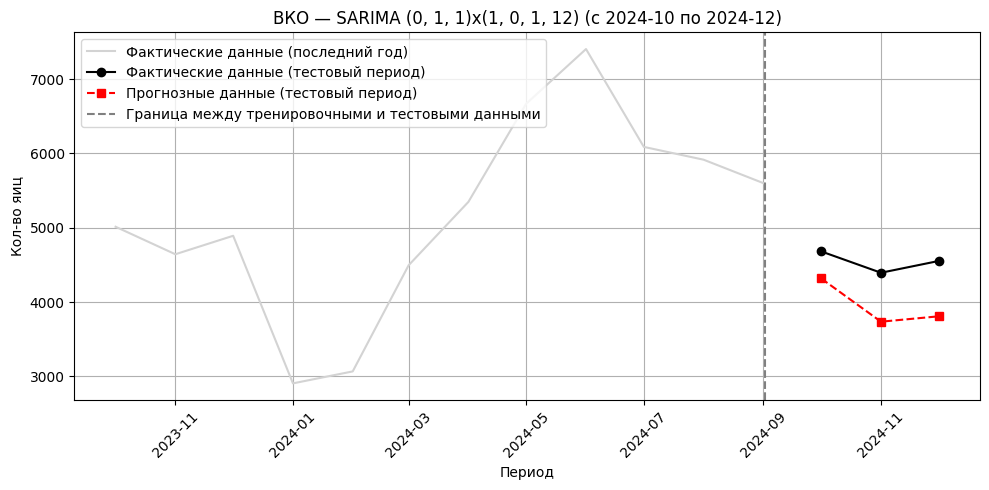

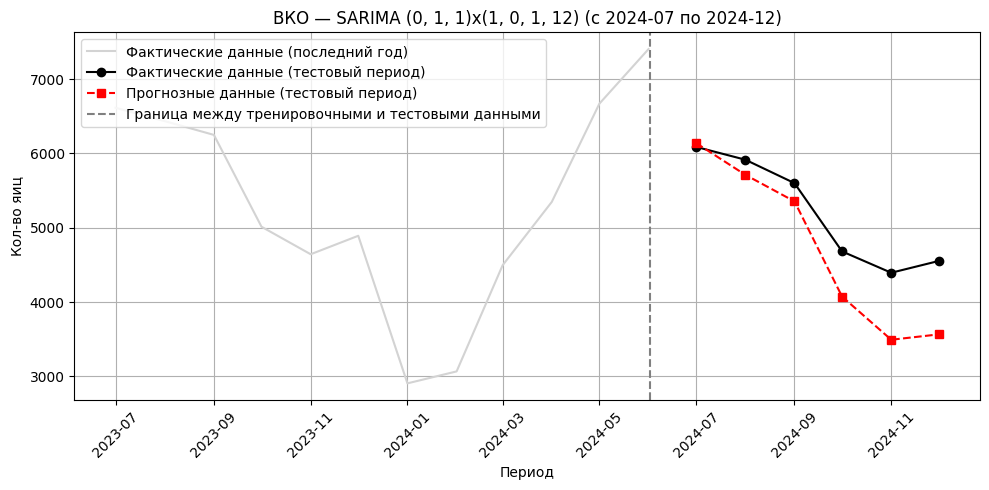

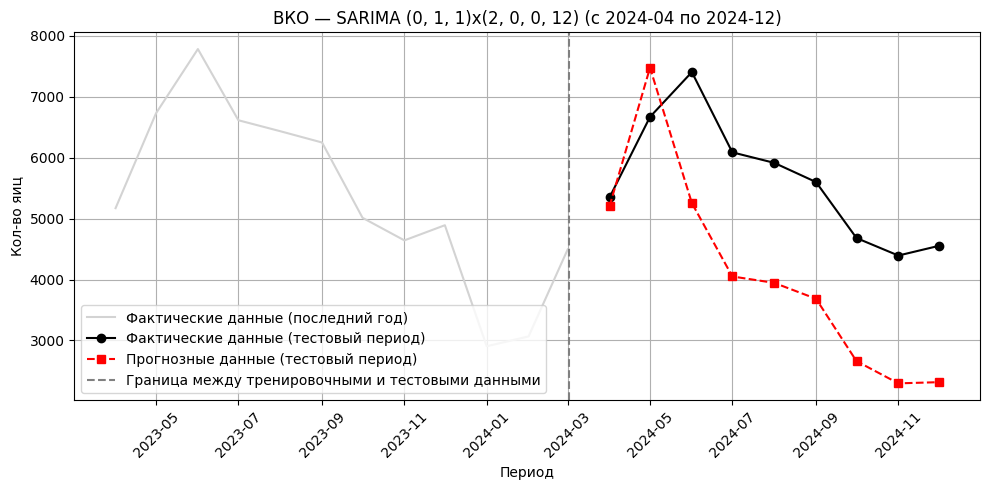

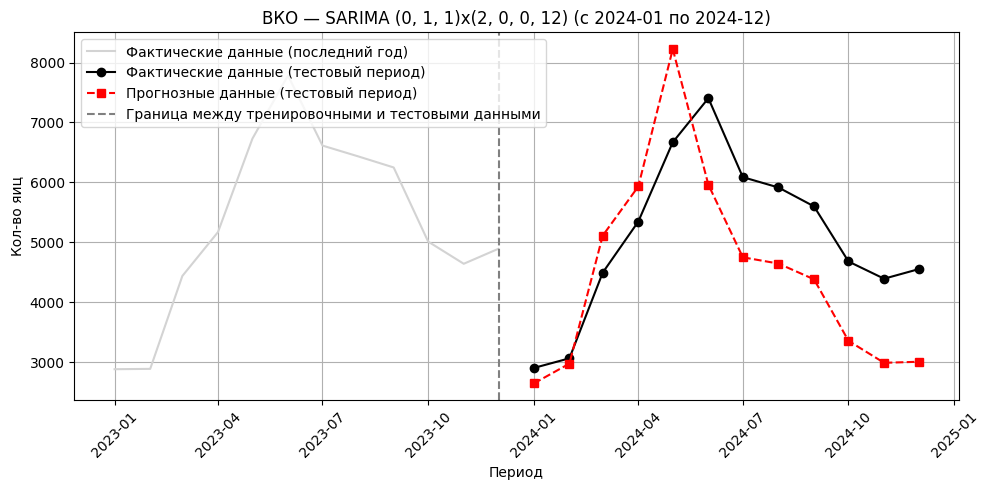

In [117]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:

    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)
    
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    try:
        model = auto_arima(
            y_train,
            seasonal=True,
            m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        forecast = model.predict(n_periods=horizon)
        forecast = pd.Series(forecast).reset_index(drop=True)

        # Оценка
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.order,
            "Seasonal order": model.seasonal_order
        })

        # График
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="red", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMA {model.order}x{model.seasonal_order} (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")

In [118]:
# Вывод метрик
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_row["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)


          Test period         RMSE          MAE   MAPE (%) SARIMA order  \
0  2024-10 to 2024-12   611.651197   589.518452  13.049027    (0, 1, 1)   
1  2024-07 to 2024-12   614.362082   499.745869  10.647697    (0, 1, 1)   
2  2024-04 to 2024-12  1840.607022  1709.207317  31.654650    (0, 1, 1)   
3  2024-01 to 2024-12  1164.955586  1053.532910  19.877802    (0, 1, 1)   
4             Average  1057.893972   963.001137  18.807294          NaN   

  Seasonal order  
0  (1, 0, 1, 12)  
1  (1, 0, 1, 12)  
2  (2, 0, 0, 12)  
3  (2, 0, 0, 12)  
4            NaN  


#### SARIMAX

In [ ]:
results = []

start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(0, 1, 1),
            seasonal_order=(1, 0, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=3, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMAX (с {start} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)



In [ ]:
results = []

horizons = [3, 6, 9, 12]

for horizon in horizons:
    # test_start = pd.to_datetime(start)
    # test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    # Split
    train_df = df[df["Период"] < test_start]
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)]

    y_train = train_df[target].reset_index(drop=True)
    y_test = test_df[target].reset_index(drop=True)

    exog_train = train_df[features].reset_index(drop=True)
    exog_test = test_df[features].reset_index(drop=True)

    try:
        model = SARIMAX(
            endog=y_train,
            exog=exog_train,
            order=(1, 0, 0),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        forecast_res = model.get_forecast(steps=horizon, exog=exog_test)
        forecast = forecast_res.predicted_mean.reset_index(drop=True)

        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)
        mape = (np.abs((y_test - forecast) / y_test).mean()) * 100

        results.append({
            "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
            "RMSE": rmse,
            "MAE": mae,
            "MAPE (%)": mape,
            "SARIMA order": model.model_orders["ar"],
            "Seasonal order": model.model_orders.get("seasonal_ar", None)
        })

        # Plot
        plt.figure(figsize=(10, 5))
        last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
        plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
        plt.plot(test_df["Период"], y_test, marker="o", color="black", label="Фактические данные (тестовый период)")
        plt.plot(test_df["Период"], forecast, marker="s", linestyle="--", color="orange", label="Прогнозные данные (тестовый период)")
        plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
        plt.title(f"ВКО — SARIMAX (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
        plt.xlabel("Период")
        plt.ylabel("Кол-во яиц")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Ошибка в периоде {start}: {e}")


In [ ]:
# Вывод метрик для SARIMAX
results_df = pd.DataFrame(results)

# Средние значения по метрикам
avg_metrics = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg_metrics["Test period"] = "Average"
avg_metrics["SARIMA order"] = ""
avg_metrics["Seasonal order"] = ""

# Добавим строку со средними значениями
results_df = pd.concat([results_df, pd.DataFrame([avg_metrics])], ignore_index=True)

# Вывод
print(results_df)

#### Prophet

20:25:39 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing


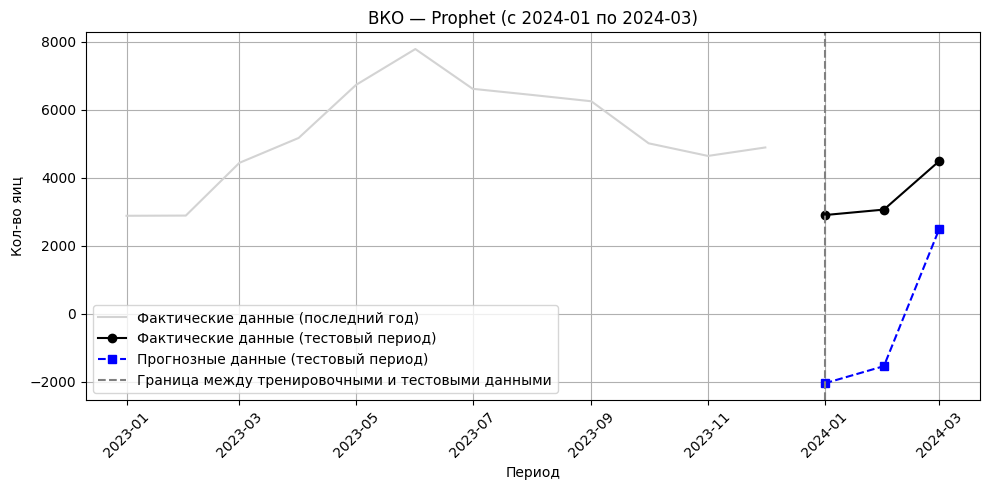

20:25:40 - cmdstanpy - INFO - Chain [1] start processing
20:25:40 - cmdstanpy - INFO - Chain [1] done processing


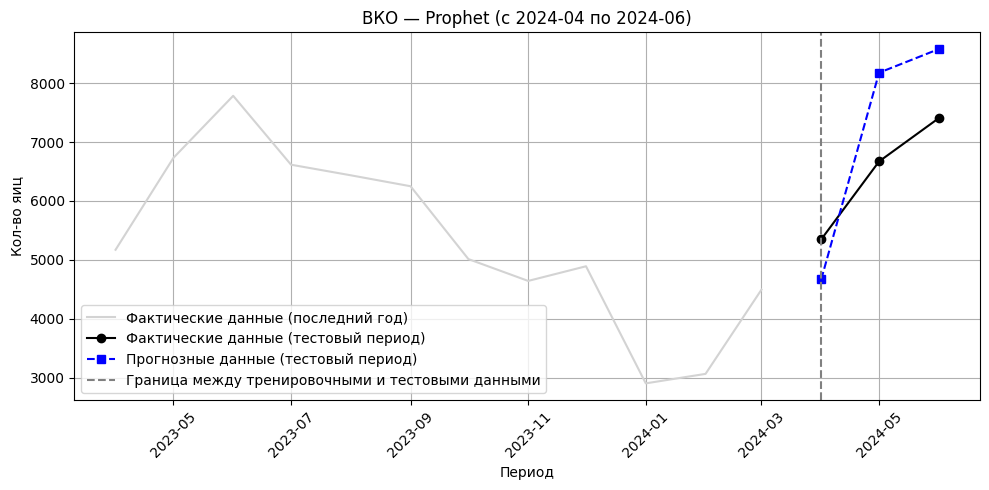

20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


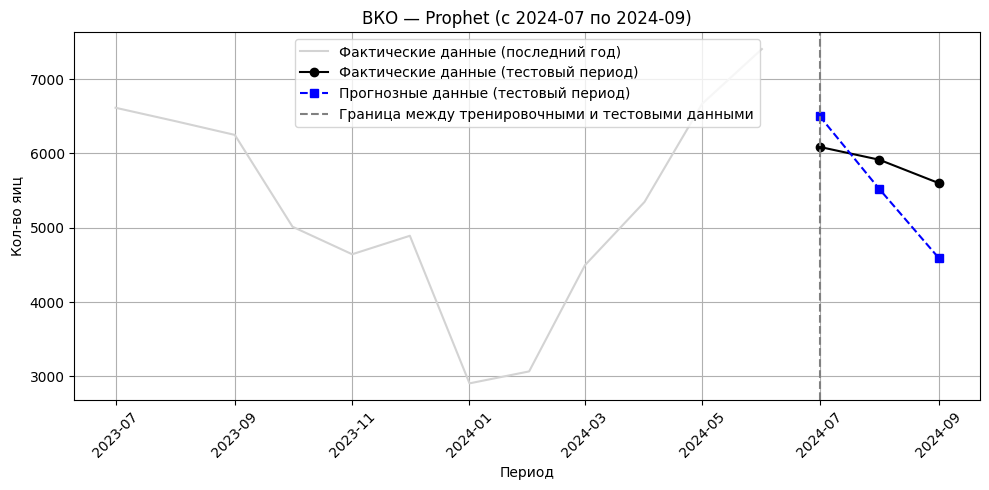

20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


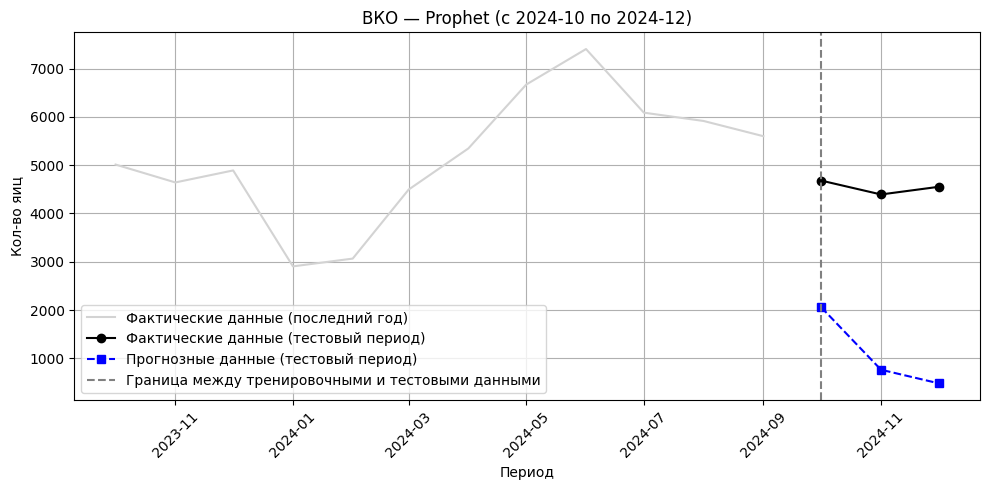

In [121]:
results = []

# Define 4 test periods
start_dates = ["2024-01", "2024-04", "2024-07", "2024-10"]

for start in start_dates:
    test_start = pd.to_datetime(start)
    test_end = test_start + pd.DateOffset(months=3) - pd.DateOffset(days=1)

    # Train/test split
    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Initialize Prophet
    model = Prophet()

    # Optional: add regressors
    # model.add_regressor("Температура_t-1")
    # prophet_train["Температура_t-1"] = train_df["Температура_t-1"].values
    # prophet_test["Температура_t-1"] = test_df["Температура_t-1"].values

    # Fit
    model.fit(prophet_train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=3, freq="M")
    forecast = model.predict(future)
# forecast
# prophet_test

    # Extract forecast for test period only
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{start} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Prophet (с {start} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [122]:
results_df = pd.DataFrame(results)
avg = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
avg["Test period"] = "Average"
results_df = pd.concat([results_df, pd.DataFrame([avg])], ignore_index=True)
print(results_df)

          Test period         RMSE          MAE    MAPE (%)
0  2024-01 to 2024-03  4065.451093  3845.450934  121.516904
1  2024-04 to 2024-06  1169.143503  1118.750112   17.029715
2  2024-07 to 2024-09   669.639939   605.814357   10.494227
3  2024-10 to 2024-12  3494.360297  3441.506618   76.020870
4             Average  2349.648708  2252.880505   56.265429


20:25:56 - cmdstanpy - INFO - Chain [1] start processing
20:25:56 - cmdstanpy - INFO - Chain [1] done processing


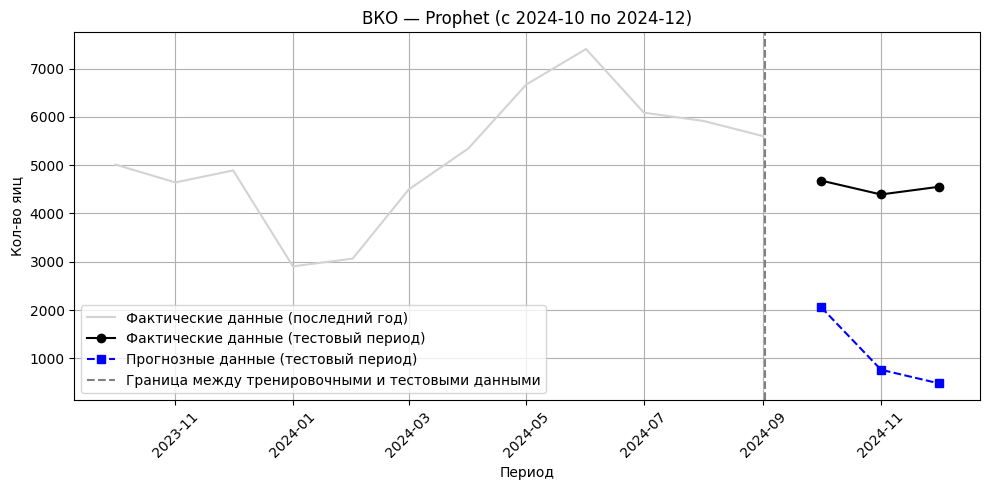

20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing


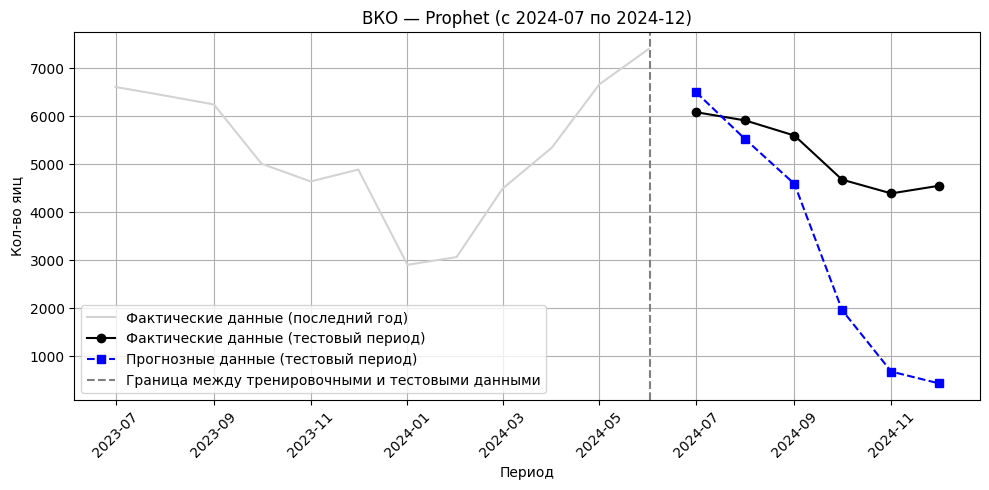

20:25:57 - cmdstanpy - INFO - Chain [1] start processing
20:25:57 - cmdstanpy - INFO - Chain [1] done processing


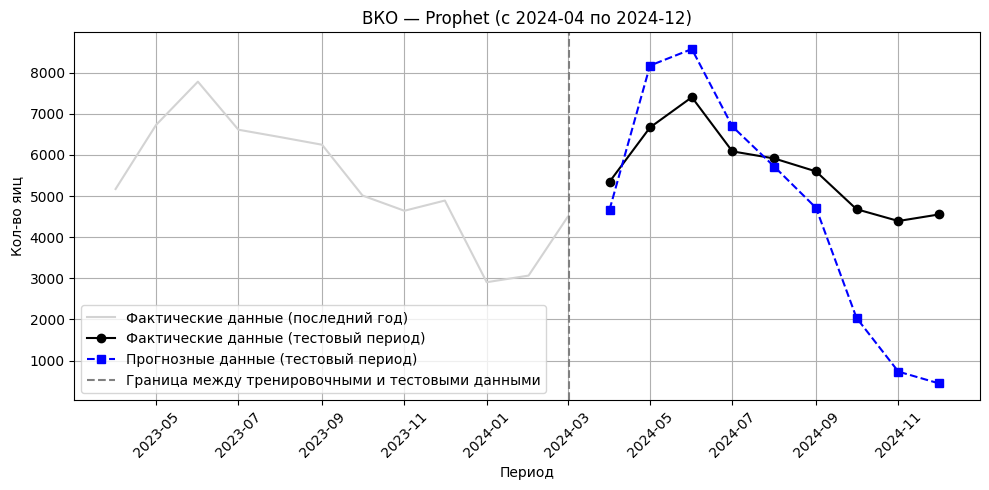

20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing


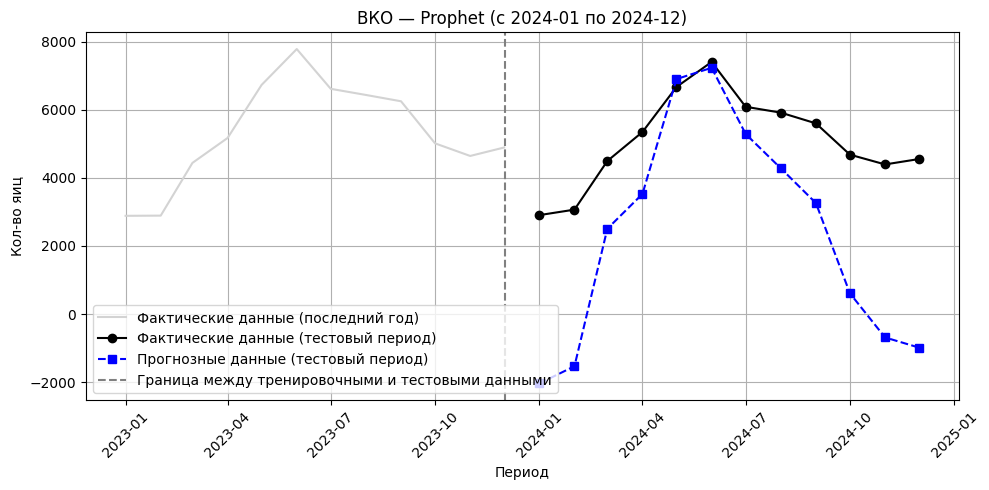

In [123]:
horizons = [3, 6, 9, 12]
results = []

for horizon in horizons:

    # Define train/test split
    test_end = pd.to_datetime("2024-12")
    test_start = test_end - pd.DateOffset(months=horizon) + pd.DateOffset(days=1)

    train_df = df[df["Период"] < test_start].copy()
    test_df = df[(df["Период"] >= test_start) & (df["Период"] <= test_end)].copy()

    # Prophet format
    prophet_train = train_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})
    prophet_test = test_df[["Период", target]].rename(columns={"Период": "ds", target: "y"})

    # Fit Prophet
    model = Prophet()
    model.fit(prophet_train)

    # Forecast
    future = model.make_future_dataframe(periods=horizon, freq="M")
    forecast = model.predict(future)

    # Extract matching forecasted months
    forecast_test = forecast[forecast["ds"].isin(prophet_test["ds"] - pd.DateOffset(days=1))].copy()
    y_pred = forecast_test["yhat"].values
    y_true = prophet_test["y"].values

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

    results.append({
        "Test period": f"{(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} to {test_end.strftime('%Y-%m')}",
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

    # Plot
    plt.figure(figsize=(10, 5))
    last_train = train_df[train_df["Период"] >= (test_start - pd.DateOffset(months=12))]
    plt.plot(last_train["Период"], last_train[target], color="lightgray", label="Фактические данные (последний год)")
    plt.plot(test_df["Период"], test_df[target], marker="o", color="black", label="Фактические данные (тестовый период)")
    plt.plot(test_df["Период"], y_pred, marker="s", linestyle="--", color="blue", label="Прогнозные данные (тестовый период)")
    plt.axvline(test_start, color="gray", linestyle="--", label="Граница между тренировочными и тестовыми данными")
    plt.title(f"ВКО — Prophet (с {(test_start + pd.DateOffset(months=1)).strftime('%Y-%m')} по {test_end.strftime('%Y-%m')})")
    plt.xlabel("Период")
    plt.ylabel("Кол-во яиц")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [124]:
# Summary table
results_df = pd.DataFrame(results)
avg_row = results_df[["RMSE", "MAE", "MAPE (%)"]].mean().to_dict()
results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

print(results_df)

          Test period         RMSE          MAE   MAPE (%)
0  2024-10 to 2024-12  3494.360297  3441.506618  76.020870
1  2024-07 to 2024-12  2567.365802  2062.735888  44.117537
2  2024-04 to 2024-12  2175.295958  1718.062058  34.478103
3  2024-01 to 2024-12  3352.890436  2769.424072  67.611291
4                 NaN  2897.478123  2497.932159  55.556950


strength of correlation:
https://link.springer.com/article/10.1057/jt.2009.5#
https://resources.nu.edu/statsresources/correlation